# EFASv5: extraer caudal
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 21-08-2023*<br>

**Introducción:**

**Por hacer**:
* [x] Aplicar el filtro por área de cuenca.

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import yaml
from pathlib import Path

## Configuración 

In [21]:
puntos = 'estaciones' # reporting_points

In [22]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
path_in = Path(cfg['rutas']['EFAS'])

In [23]:
path_out = f'../data/EFASv5/caudal/{puntos}/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

## Puntos
### Estaciones ROEA

In [24]:
if puntos == 'estaciones':
    estaciones = gpd.read_file('../data/anuario_aforos/GIS/estaciones_seleccion_EFASv5.shp')
    estaciones.set_index('indroea', drop=True, inplace=True)

    # xarrys with station coordinates that will be used to extract data
    x = xr.DataArray(estaciones.geometry.x, dims='id')
    y = xr.DataArray(estaciones.geometry.y, dims='id')

**Comprobar área de cuenca**

In [31]:
if puntos == 'estaciones':
    
    # cargar mapa de área de cuenca
    area = xr.open_mfdataset(f'{path_in}/maps/upArea*.nc', chunks='auto')['Band1']

    # extraer el área de cuenca de las estaciones
    area = area.sel(lon=x, lat=y, method='nearest').compute()
    area = area.drop(['lon', 'lat'])
    area = area.to_pandas()
    area /= 1e6 # m2

    dif_area = ((area - estaciones.suprest) / estaciones.suprest * 100).sort_values(ascending=False)

    print(dif_area.head(10))

id
3049    77.521382
9322    32.668354
2150    19.155348
4207    17.684399
3251    17.339349
3246    17.229219
2104    15.944291
5136    15.683429
1443    14.871448
8126    14.372974
dtype: float64


### Puntos de EFAS

In [ ]:
if puntos == 'reporting_points':
    puntos_EFAS = pd.read_csv('E:/casadje/GitHub/EFAS_skill/data/reporting_points/Station-2022-10-27v12_KGE.csv', index_col='station_id')
    puntos_EFAS['Country code'] = puntos_EFAS['Country code'].str.upper()

In [ ]:
    # filtrar por país
    puntos_EFAS = puntos_EFAS.loc[puntos_EFAS['Country code'] == 'ES']

In [ ]:
    puntos_EFAS.to_csv('../EFAS/points/points.csv')

In [ ]:
    puntos_EFAS.shape

In [ ]:
    puntos_EFAS.FixedRepPoint.value_counts()

In [ ]:
    sns.displot(puntos_EFAS['DrainingArea.km2.LDD'])

In [ ]:
    puntos_EFAS.columns

In [ ]:
    puntos_EFAS.ObsID.unique()

### Reanálisis de caudal EFAS

In [33]:
# load dataset and extract variable discharge
dis = xr.open_mfdataset(f'{path_in}/reanalysis/dis_*.nc', chunks='auto')['dis']
dis.close()

# extract discharge for the selected stations
dis = dis.sel(lon=x, lat=y, method='nearest')
dis = dis.drop(['lon', 'lat'])

# resample to daily timesteps. WARNING! The data is shifted 6 h!!!
#dis['time'] = dis.time + np.timedelta64(6, 'h')
dis = dis.resample(time='1D').mean()

# compute the lazy DataArray
dis = dis.compute()
dis.name = 'discharge'

OSError: no files to open

In [20]:
# exportar las series
dis.to_netcdf(f'{path_out}dis_{dis.time.min().dt.year.data}_{dis.time.max().dt.year.data}.nc')

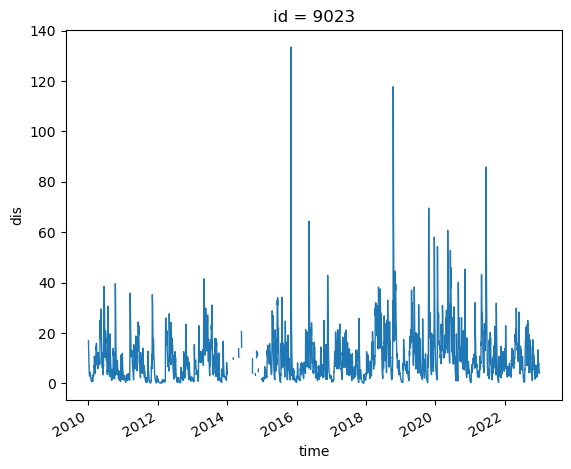

In [6]:
dis.sel(id='9023').plot(lw=1);